In [ ]:
import numpy as np
import pandas as pd
import pickle
from ipywidgets import interact
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import DBSCAN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_path = 'drive/My Drive/Project_DL/'
import sys
sys.path.append(drive_path)

In [ ]:
df0 = pd.read_parquet(drive_path+'pass0.parquet')
df1 = pd.read_parquet(drive_path+'pass1.parquet')

def get_timestamps(row):
    # algin obd.spd_veh and acc
    # row = df0.iloc[k]
   
    mask = row['GM.T'] == 'acc.xyz'
    accT = row['GM.TS_or_Distance'][mask]
    obdT = row['GM.TS_or_Distance'][~mask]
    return accT, obdT

In [ ]:
# print(list(df0))
df0.head()

,IRI_mean,IRI_sequence,GM.TS_or_Distance,GM.T,GM.lat_int,GM.lon_int,GM.acc.xyz.z,GM.acc.xyz.y,GM.acc.xyz.x,GM.obd.spd_veh.value
0,4.933540,"[6.644882798499999, 5.5573473115, 7.666319952,...","[2021-04-22T01:21:54.349000000, 2021-04-22T01:...","[acc.xyz, acc.xyz, acc.xyz, acc.xyz, obd.spd_v...","[55.654713308383236, 55.65471373053892, 55.654...","[12.486686901197604, 12.486686532934131, 12.48...","[0.9727, 0.9727, 0.9727, 0.9727, 0.9922, 0.992...","[-0.1172, -0.1172, -0.1172, -0.1172, -0.1211, ...","[0.1602, 0.1602, 0.1602, 0.1602, 0.1563, 0.156...","[31.04, 31.0, 30.970000000000002, 31.470000000..."
1,4.696225,"[5.5573473115, 7.666319952, 4.1605364705, 5.35...","[2021-04-22T01:21:55.068000000, 2021-04-22T01:...","[acc.xyz, acc.xyz, acc.xyz, acc.xyz, acc.xyz, ...","[55.654781462897525, 55.65478160070671, 55.654...","[12.48662899293286, 12.486628876325089, 12.486...","[0.9727, 0.9727, 0.9727, 0.9727, 0.9727, 0.972...","[-0.0898, -0.0898, -0.0898, -0.0898, -0.0898, ...","[0.1406, 0.1406, 0.1406, 0.1406, 0.1406, 0.140...","[29.52, 29.48, 29.42, 29.400000000000002, 29.3..."
2,4.699145,"[7.666319952, 4.1605364705, 5.359907053000001,...","[2021-04-22T01:21:56.327000000, 2021-04-22T01:...","[acc.xyz, acc.xyz, acc.xyz, acc.xyz, acc.xyz, ...","[55.654862308917195, 55.65486260509554, 55.654...","[12.486560579617835, 12.486560331210192, 12.48...","[1.0391, 1.0391, 1.0391, 1.0391, 1.0391, 1.015...","[0.0273, 0.0273, 0.0273, 0.0273, 0.0273, 0.011...","[0.1523, 0.1523, 0.1523, 0.1523, 0.1523, 0.160...","[30.080000000000002, 30.14, 30.2, 30.23, 29.54..."
3,4.397566,"[4.1605364705, 5.359907053000001, 4.5512844555...","[2021-04-22T01:21:57.983000000, 2021-04-22T01:...","[acc.xyz, acc.xyz, acc.xyz, acc.xyz, acc.xyz, ...","[55.654942544169614, 55.65494265017668, 55.654...","[12.486492964664311, 12.486492879858657, 12.48...","[1.0391, 1.0391, 0.9805, 0.9805, 0.9805, 0.980...","[0.1016, 0.1016, 0.0898, 0.0898, 0.0898, 0.089...","[0.2188, 0.2188, 0.1953, 0.1953, 0.1953, 0.195...","[36.910000000000004, 37.0, 37.07, 37.18, 37.25..."
4,4.400549,"[5.359907053000001, 4.5512844555, 5.8527534034...","[2021-04-22T01:21:59.120000000, 2021-04-22T01:...","[obd.spd_veh, acc.xyz, acc.xyz, acc.xyz, acc.x...","[55.65502238338658, 55.65502269329073, 55.6550...","[12.486424923322684, 12.486424661341852, 12.48...","[0.9492, 0.9961, 0.9961, 0.9961, 0.9961, 0.996...","[0.0859, 0.0977, 0.0977, 0.0977, 0.0977, 0.097...","[0.1875, 0.1563, 0.1563, 0.1563, 0.1563, 0.156...","[41.2, 41.27, 41.38, 41.46, 41.53, 40.76, 41.6..."


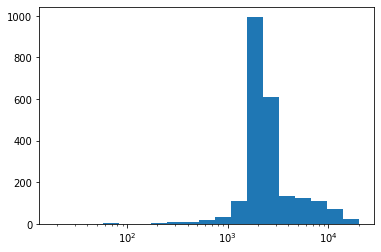

In [ ]:
def plot_loghist(x, bins):
    logbins = np.logspace(np.log10(min(x)),np.log10(max(x)),bins)
    plt.hist(x, bins=logbins)
    plt.xscale('log')
    plt.show()

# most recordings last ~2000 steps
zacc = df0['GM.acc.xyz.z']
plot_loghist(zacc.map(len), bins=20)

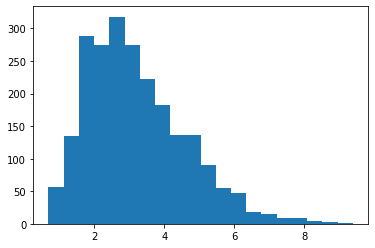

In [ ]:
# distribution of IRI mean
iri = df0['IRI_mean']
plt.hist(iri, bins=20);

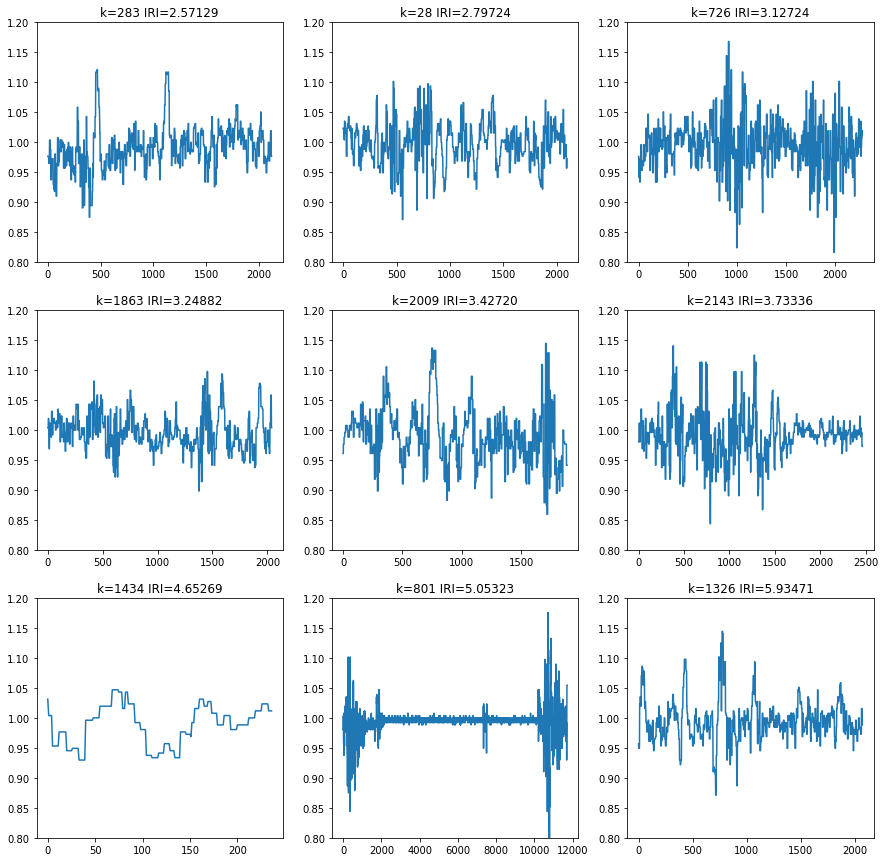

In [ ]:
n = len(zacc)
nbs = list(np.random.randint(0,n,9))
nbs.sort(key=lambda k: iri.iloc[k])
nbs = np.array(nbs).reshape(3,3)

fig, ax = plt.subplots(3,3, figsize=(15,15))
for i in range(3):
    for j in range(3):
        k = nbs[i,j]
        ax1 = ax[i,j]
        ax1.plot(zacc.iloc[k])
        ax1.set_ylim(.8,1.2)
        ax1.set_title("k=%d IRI=%.5f" % (k, iri[k]))
        #ax2 = ax1.twinx().twiny()
        #ax2.plot(df0['IRI_sequence'].iloc[k], c='orange')

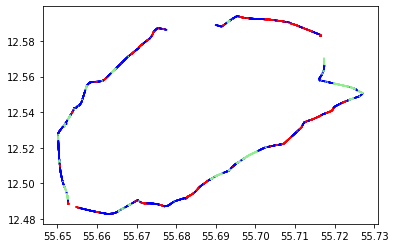

In [ ]:
# snouglou
for _, row in df0.iterrows():
    riri = row['IRI_mean']
    c = 'red' if riri > 4 else 'lightgreen' if riri < 2 else 'blue' 
    plt.plot(row['GM.lat_int'], row['GM.lon_int'], c=c)

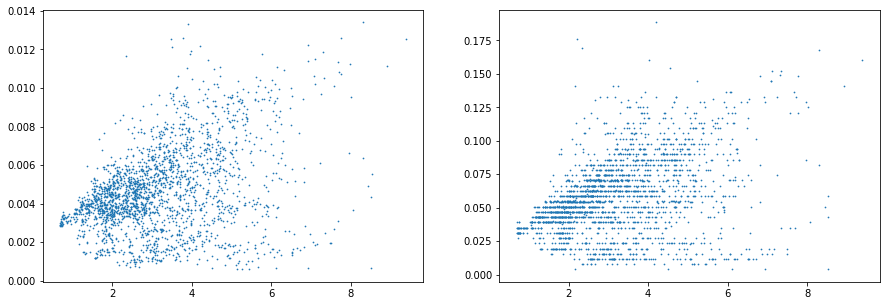

In [ ]:
def mean_delta(seq):
    return np.abs(seq[1:] - seq[:-1]).mean()

def quantile_diff(seq, q=.15):
    return np.quantile(seq, 1-q) - np.quantile(seq, q)

a,b = zacc.map(mean_delta), zacc.map(quantile_diff)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(iri, a, s=.5)
ax[1].scatter(iri, b, s=.5);

In [ ]:
# np.corrcoef(iri, a)
np.corrcoef(iri, b)
# IRI is correlated with the displacement

array([[1.        , 0.35654905],
       [0.35654905, 1.        ]])

In [ ]:
speed = df0['GM.obd.spd_veh.value']
min(speed.map(min)), max(speed.map(max))

(0.0, 63.24)

In [ ]:
dts = df0['GM.TS_or_Distance'].map(np.diff)
# dts = dts[dts.map(len) > 2048].map(lambda x: x[:2048]).reset_index(drop=True)
dts = np.concatenate(dts).astype('float') / 1e9
len(dts[dts > 1])

413

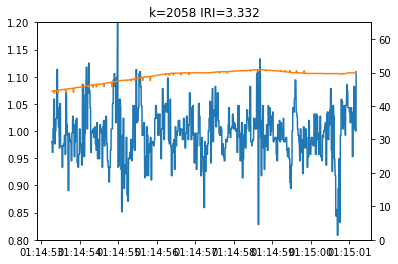

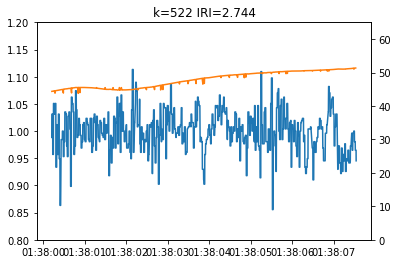

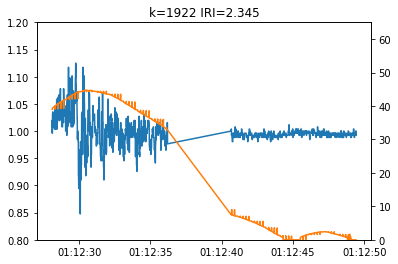

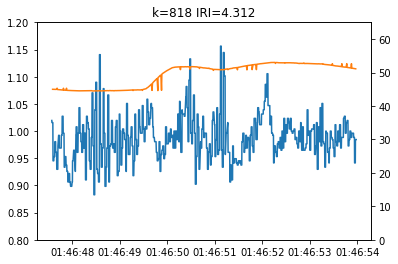

In [ ]:
for _ in range(4):
    i = np.random.randint(0,n)
    s0 = df0.loc[i]
    accT, obdT = get_timestamps(s0)
    accZ = s0['GM.acc.xyz.z']
    obd = s0['GM.obd.spd_veh.value']
    # obd = gaussian_filter1d(obd, 3)
    
    # plt.plot(accZ)
    fig, ax1 = plt.subplots()
    ax1.set_title('k=%d IRI=%.3f' % (i,iri[i]))
    ax2 = ax1.twinx()
    ax1.plot(accT, accZ, color='#1f77b4')
    ax1.set_ylim(.8, 1.2)
    ax2.plot(obdT, obd, color='#ff7f0e')
    ax2.set_ylim(0, 65);

# we notice some clipping on the orange curve (?)

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class TruncatedDS(Dataset):
    """
    In this dataset, all time series are truncated to the 0.1 quantile
    or size, if provided
    """
    def __init__(self, fname, size=None, align=32):
        df = pd.read_parquet(fname)
        zacc = df['GM.acc.xyz.z'] # Series[arr[:]float]
        iri = df['IRI_mean'] # Series[float]
        
        if not size:
            size = zacc.map(len).quantile(.1)
            size = (int(size) // align) * align
        self.sz = size
        mask = zacc.map(len) >= size
        zacc = zacc[mask]
        iri = iri[mask]
        
        def truncate(arr):
            return arr[:size]
        zacc = np.stack(zacc.map(truncate)).astype('float32')
        # print(zacc.shape, size)
        self.zacc = zacc
        self.iri = iri.values.astype('float32')
        
        print('TruncatedDS initialized with size = %d, len = %d' % (size,len(zacc)))
        
    
    def __getitem__(self, idx):
        return self.zacc[idx][None,:], self.iri[idx]
    
    def __len__(self):
        return len(self.zacc)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# https://keras.io/examples/timeseries/timeseries_anomaly_detection/
class AE1(nn.Module):
    def __init__(self, din=1, depth=2, w=7, h1=16, h2=1):
        super().__init__()
        assert depth >= 2
        pad = {'padding':'same', 'padding_mode':'reflect'}
        
        enc = [
            nn.Conv1d(din, h1, w, **pad),
            nn.MaxPool1d(2,2),
            nn.ReLU(),
            nn.Dropout(.2),
        ]
        dec = [
            nn.Conv1d(h1, h1, w, **pad),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv1d(h1, din, w, **pad),
        ]
        for _ in range(2, depth):
            enc += [
                nn.Conv1d(h1, h1, w, **pad),
                nn.MaxPool1d(2,2),
                nn.ReLU(),
                nn.Dropout(.2),
            ]
            dec = [            
                nn.Conv1d(h1, h1, w, **pad),
                nn.ReLU(),
                nn.Upsample(scale_factor=2),
                nn.Dropout(.2),
            ] + dec
        enc += [
            nn.Conv1d(h1, h2, w, **pad),
            nn.MaxPool1d(2,2),
            nn.ReLU(),
        ]
        dec = [
            nn.Conv1d(h2, h1, w, **pad),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Dropout(.2),
        ] + dec
        
        self.encoder = nn.Sequential(*enc)
        self.decoder = nn.Sequential(*dec)
        
    def forward(self, x):
        encoded = self.encoder(x)
        # print(encoded.shape)
        decoded = self.decoder(encoded)
        return decoded
    def get_latent(self,x):
        return self.encoder(x)
    
#encoder is a convnet with MaxPool at each layer 
#

In [ ]:
def get_trivial_mse(dataset, scale=8): #base case interpolation to comparrr
    def get_one(x):
        x,_ = x
        x1 = F.avg_pool1d(x,scale,scale)
        x1 = F.interpolate(x1, scale_factor=scale)
        return F.mse_loss(x1,x)

    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
    return float(np.array(list(map(get_one, dataloader))).mean())

In [ ]:
def train(model, dataset, epochs, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    hist = []
    for epoch in tqdm(range(epochs)):
        running_loss = 0
        for x,_ in dataloader:
            pred = model(x)
            loss = loss_fn(pred, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += float(loss) * x.size(0)

        hist.append(running_loss / len(dataset))
    return hist

In [ ]:
# dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
# model = AE1()
# model(next(iter(dataloader)))

In [ ]:
L = 2048
dataset = TruncatedDS(drive_path+'pass0.parquet', L)
dataloader = DataLoader(dataset, shuffle=True)

TruncatedDS initialized with size = 2048, len = 1460


In [ ]:
def TSNE_visualization(x,mean,n_components=2,perplexity=200,n_iter=5000,display = True):
      tsne = TSNE(n_components=n_components, n_iter=n_iter,perplexity=perplexity)
      vis = tsne.fit_transform(x)
      if display:
        data = pd.DataFrame()
        data['mean'] = mean
        def separate(x,n):
          if x < n:
            return "<"+str(n)
          else:
            return ">"+str(n)
        data['mean'] = data['mean'].apply(lambda i: separate(i,4))
        data['tsne-2d-one'] = vis[:,0]
        data['tsne-2d-two'] = vis[:,1]
        plt.figure(figsize=(16,10))
        sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="mean",
        palette=sns.color_palette("bright", data['mean'].nunique()),
        data=data,
        legend="full",
        alpha=0.3)
      else:
        return vis

In [ ]:
models = []
def train_model(epochs=40, batch_size=4, **kwargs):
    model = AE1(**kwargs)
    hist = train(model, dataset, epochs, batch_size)
    models.append((model, hist, kwargs))

In [ ]:
# train_model(depth=4, h2=4)
train_model(epochs=10, depth=2, h2=4)

100%|██████████| 10/10 [00:48<00:00,  4.88s/it]


In [ ]:
scale = 4
print('compression x%d, trivial MSE: %f' % (scale, get_trivial_mse(dataset, scale)))
scale = 32
print('compression x%d, trivial MSE: %f' % (scale, get_trivial_mse(dataset, scale)))

compression x4, trivial MSE: 0.000183
compression x32, trivial MSE: 0.000787


In [ ]:
def show_report(model):
    model, hist, _ = models[model]
    fig, ax = plt.subplots(1,2, figsize=(15,5))

    ax[0].plot(hist)
    ax[0].set_yscale('log')

    with torch.no_grad():
        x,iri = next(iter(dataloader))
        ax[1].plot(x[0,0].numpy())
        ax[1].plot(model(x)[0,0].numpy())
        ax[1].set_ylim(.8, 1.2)
        
interact(show_report, model=[((i,models[i][2]), i) for i in range(len(models))]);

interactive(children=(Dropdown(description='model', options=(((0, {'depth': 2, 'h2': 4}), 0),), value=0), Outp…

k=283 IRI=2.57129
k=1186 IRI=2.46138
k=217 IRI=4.67055


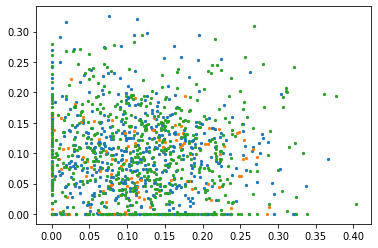

In [ ]:
## visualization

### FAIS TSNEEEEEE ici

model = models[0][0]

for _ in range(3):
    i = np.random.randint(0,n)
    x = torch.tensor(zacc[i].astype('float32')).view(1,1,-1)
    with torch.no_grad(): #so we don't trainnn 
        x = model.encoder(x).numpy()
    print("k=%d IRI=%.5f" % (i, iri[i]))
    plt.scatter(*x[0,2:], s=5);

In [ ]:
latent = []
mean = []
for x in dataloader:
  with torch.no_grad(): #so we don't trainnn 
        l = model.encoder(x[0])
  latent.append(l.detach().numpy()[0][0])
  mean.append(x[1].detach().numpy()[0])
print(len(latent[0]))
#print(len(mean))

512


In [ ]:
x = TSNE_visualization(latent,mean,n_components=2,perplexity=100,n_iter=2000,display=None)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


KeyboardInterrupt: ignored

In [ ]:
db=DBSCAN(eps=1.85, min_samples=1000)
db.fit(x)
y_pred = db.fit_predict(x)
plt.figure(figsize=(10,6))
plt.scatter(x[:,0], x[:,1],c=y_pred, cmap='Paired')
plt.title("Clusters determined by DBSCAN")

In [ ]:
## prediction

batch_size = 4
epochs = 4

rnn = nn.LSTM(input_size=4, hidden_size=32, num_layers=1, proj_size=1, batch_first=True)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=1e-3)

hist = []
for epoch in (range(epochs)):
    running_loss = 0
    for x,iri in tqdm(dataloader):
        with torch.no_grad():
            z = model.encoder(x)
        y,_ = rnn(torch.transpose(z,1,2))
        loss = loss_fn(y[:,-1,0], iri)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print(loss)

        running_loss += float(loss) * x.size(0)

    hist.append(running_loss / len(dataset))


In [ ]:
plt.plot(hist)

In [ ]:
## prediction

batch_size = 4
epochs = 4

rnn = nn.LSTM(input_size=1, hidden_size=32, num_layers=1, proj_size=1, batch_first=True)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=1e-3)

hist = []
for epoch in (range(epochs)):
    running_loss = 0
    for x,iri in tqdm(dataloader):
        y,_ = rnn(torch.transpose(x,1,2))
        loss = loss_fn(y[:,-1,0], iri)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print(loss)

        running_loss += float(loss) * x.size(0)

    hist.append(running_loss / len(dataset))


In [ ]:
plt.plot(hist)

In [ ]:
linreg = nn.Linear(1,1)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(linreg.parameters(), lr=1e-3)

hist = []
for epoch in tqdm(range(30)):
    running_loss = 0
    for x,iri in (dataloader):
        z = np.mean(np.abs(np.diff(np.array(x))), axis=-1)[:,None]
        z = torch.tensor(z)
        y = linreg(z)
        loss = loss_fn(y[:,-1,0], iri)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print(loss)

        running_loss += float(loss) * x.size(0)

    hist.append(running_loss / len(dataset))


In [ ]:
plt.plot(hist);

In [ ]:
list(linreg.parameters())